In [37]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
%matplotlib inline

In [38]:
from scipy.signal import butter, lfilter, freqz
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

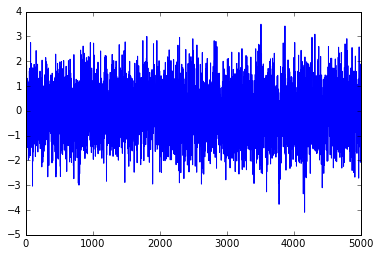

In [39]:
# generate stimulation
nsample = 5000
ss = np.zeros(nsample)
for i in range(nsample):
    ss[i] = gauss(0,1)
    
plt.plot(ss)
plt.show()

(0, 300)

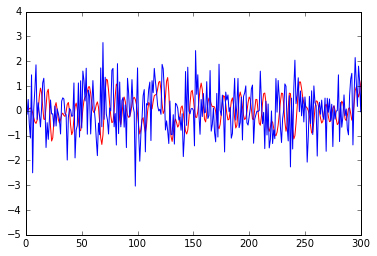

In [40]:
cutoff = 10
fs = 60
order = 6
y = butter_lowpass_filter(ss, cutoff, fs, order)
plt.plot(y,'r')
plt.plot(ss,'b')
plt.xlim([0,300])

In [67]:
# model parameters
Delta = 0.1
Gamma = 0.1
sDD = 0.01
omega2 = 0.25
prms = {}
for n in ['Delta','Gamma','sDD','omega2']:
    prms[n] = eval(n)
print(prms)

{'sDD': 0.01, 'Gamma': 0.1, 'Delta': 0.1, 'omega2': 0.25}


In [42]:
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

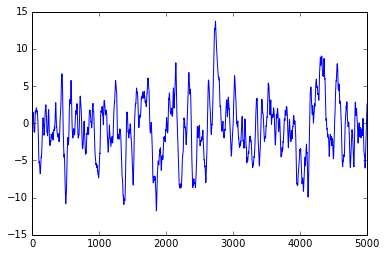

In [43]:
# generate the stochastic sequence
ts = []
vs = []
t = 0
v = 0
for i in range(nsample):
    tp = t
    t = t+v*Delta
    v = (1-Gamma)*v-omega2*tp*Delta+gauss(0,sDD)
    ts.append(t*100)
    vs.append(v)
plt.plot(ts)

(0, 1000)

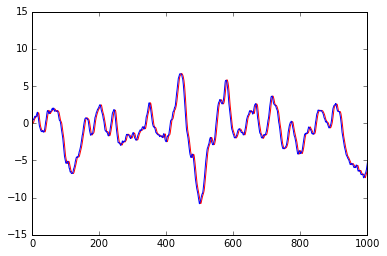

In [68]:
# 
cutoff = 10
fs = 60
order = 6
y = butter_lowpass_filter(ts, cutoff, fs, order)
plt.plot(y,'r')
plt.plot(ts,'b')
plt.xlim([0,1000])

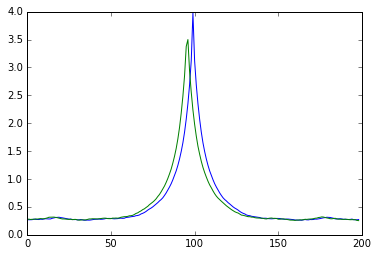

In [45]:
dms = range(-99,100)
ais = [mi_quick(ts,ts,d) for d in dms]
mi_lowpass = [mi_quick(ts,y,d) for d in dms]
plt.plot(ais)
plt.plot(mi_lowpass)

In [46]:
# r[m] = s[m] + (s[m] - s[m-1])*dt
# r[m] = s[m]*(1+dt) - s[m-1]*dt
# r[m] = convolution(s,k_t) with k[0] = (1+dt) k[1] = -dt

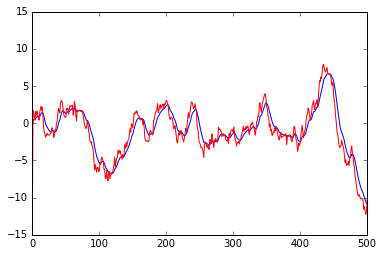

In [47]:
# convolution
dt =5.0
rr = np.zeros(nsample)
k_len = 2
k_t = np.zeros(k_len)
k_t[0] = (1.+dt) 
k_t[1] = -dt

result=np.convolve(ts,k_t)

result = np.zeros(nsample)
result[0]= ts[0]
for i in range(nsample-1):
    result[i] = ts[i]+ (ts[i]-ts[i-1])*dt 
#result = np.convolve(ts,k_t)
plt.plot(ts,'b')
plt.plot(result,'r')
#plt.plot(result-rr)
plt.xlim([0,500])
plt.show()


In [48]:
yy = np.zeros(nsample)
yy = result[0:nsample]
yy.shape

(5000,)

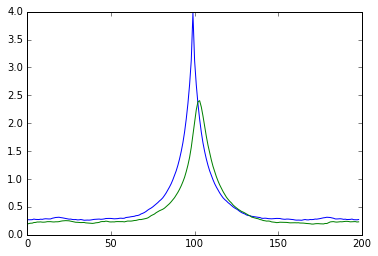

In [49]:
yy = result[0:nsample]
mi_con = [mi_quick(ts,yy,d) for d in dms]
plt.plot(ais)
plt.plot(mi_con)

In [50]:
# prediction the $\tau$ at $n$ steps later from existing observations
def predict_tau(ts,n=1):
    tp = 0
    pts = []
    pvs = []
    for t in ts:
        vp = (t-tp)/Delta
        v = (1-Gamma)*vp-omega2*tp*Delta
        pt = t
        for i in range(n):
            tp = pt
            pt = pt+v*Delta
            v = (1-Gamma)*v-omega2*tp*Delta
        pts.append(pt)
        pvs.append(v)
        tp = t
    return pts,pvs

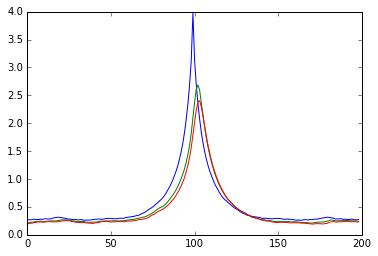

In [51]:
dms = range(-99,100)
pts10,pvs10 = predict_tau(ts,5)
mis10 = [mi_quick(ts,pts10,d) for d in dms]
plt.plot(ais)
plt.plot(mis10)
plt.plot(mi_con)

In [64]:
#print(mis10)
aa87=range(1,6)
aaa87 = [mi_quick(ts,pts10,aa) for aa in aa87]
print(aaa87)

[2.3817187299662379, 2.6093567173106673, 2.6875257483377339, 2.5919092406427402, 2.3690833369739717]
